<a href="https://colab.research.google.com/github/juanmed/dw_a/blob/main/package_detection_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 460kB 51.1MB/s 
     |████████████████████████████████| 3.0MB 44.2MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2449, done.
remote: Counting objects: 100% (2449/2449), done.
remote: Compressing objects: 100% (2044/2044), done.
remote: Total 2449 (delta 592), reused 1337 (delta 378), pack-reused 0
Receiving objects: 100% (2449/2449), 30.84 MiB | 18.01 MiB/s, done.
Resolving deltas: 100% (592/592), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624302 sha256=2e56f77e9af8a9cd1e9490f0696eadc866cd3244ace4595be620accfd9037ad0
  Stored in directory: /tmp/pip-ephem-wheel-cache-aaixgc30/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp37-none-any.whl size=43735 sha256=6e44b0e6716597dfc69d635134edca49f566a6b6c4da2637b28615bbae39e738
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=ef9ae57fb06f75494ffbb460566659e52dcecde10730decd46ec86c97587b346
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=0104876ca46f3fbcd8b89ba0df75b4982a720cb66d87871780f5

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [4]:
!pip install zipfile36
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=b8ab7d7d40bbfe5a37332ebfc3116e0f8862c11cbb98021385f4b0da41882aac
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
import pathlib as pl

images_path = "./images"
model_path = "./model"

if not os.path.exists(images_path):
  pl.Path(images_path).mkdir(parents=True, exist_ok=True)
if not os.path.exists(model_path):
  pl.Path(model_path).mkdir(parents=True, exist_ok=True)

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def download_images():
    base_url = 'https://raw.githubusercontent.com/juanmed/dw_a/main/dll_package_recognition/'
    filenames = ['pkrecog_002_0005.jpg', 'pkrecog_003_0011.jpg', 'pkrecog_004_0010.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths

IMAGE_PATHS = download_images()


499712/498006 [==============================] - 0s 0us/step


In [15]:
import shutil
#for img in IMAGE_PATHS:
  #shutil.move(img, "./images/")

IMAGE_PATHS = os.listdir("./images")
IMAGE_PATHS = ["./images/" + f for f in IMAGE_PATHS ]

In [16]:
IMAGE_PATHS

['./images/pkrecog_004_0010.jpg',
 './images/pkrecog_002_0005.jpg',
 './images/pkrecog_003_0011.jpg']

In [8]:
# Download and extract model
import gdown

url = 'https://drive.google.com/uc?id=1v9N2JlGzybKutPrE9kHOmjutlI1spUfM'
output = 'ssd_512x512_batch4.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1v9N2JlGzybKutPrE9kHOmjutlI1spUfM
To: /content/ssd_512x512_batch4.zip
236MB [00:00, 267MB/s]


'ssd_512x512_batch4.zip'

In [9]:
import sys
if sys.version_info >= (3, 6):
    import zipfile
else:
    import zipfile36 as zipfile
# Create a ZipFile Object and load sample.zip in it
with zipfile.ZipFile(output, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(model_path)

In [10]:
import wget
labelmap_url = "https://raw.githubusercontent.com/juanmed/dw_a/main/dll_package_recognition/label_map.pbtxt"
labelmap_file = wget.download(labelmap_url)

In [11]:
# Install COCO evaluation tools
%%bash 
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
make
cp -r pycocotools ../../models/research/

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I../common -I/usr/include/python3.7m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/

Cloning into 'cocoapi'...
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=!v; }}
       ^~~
../common/maskApi.c:46:49: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the ‘for’
       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=!v; }}
                                                 ^
../common/maskApi.c: In function ‘rleFrPoly’:
../common/maskApi.c:166:3: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
   ^~~
../common/maskApi.c:166:54: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the ‘for’
   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
                                                      ^
../common/maskApi.c:167:3: warning: this ‘for’ clause does 

In [12]:
import time
import tensorflow as tf 
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = model_path + "/my_model" + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 13.650826454162598 seconds


In [13]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_file,
                                                                    use_display_name=True)

Running inference for ./images/pkrecog_004_0010.jpg... Done
Running inference for ./images/pkrecog_002_0005.jpg... Done
Running inference for ./images/pkrecog_003_0011.jpg... Done


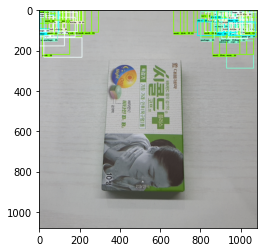

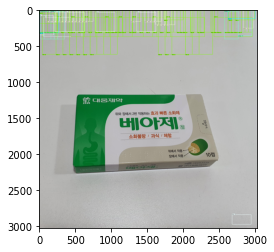

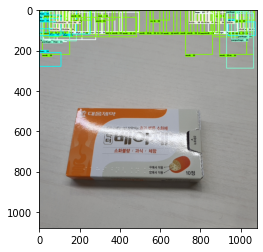

In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.01,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2